# 量子测量噪声缓释

*版权所有 (c) 2022 百度量子计算研究所，保留所有权利。*

## 内容概要

测量是提取量子线路的运行结果的手段，而由于各种原因，测量设备会包含噪声，导致后续基于测量结果的计算结果会出现偏差，对测量噪声进行缓释就非常重要。本教程将介绍量子测量噪声缓释的理论及其在[百度量子平台](https://quantum.baidu.com/)上的实践。

## 理论
量子线路的的结果需要通过测量得到，而测量在实际操作中会因为仪器等问题引起误差。

一类经典的量子算法框架是：制备初始态——量子电路演化——测量——计算期望值。许多著名的量子算法，如量子变分求解器 [1]，量子近似化算法 [2]，量子机器学习 [3,4] 等抽象出来都是这样的算法框架。

实验数据 [5,6] 和理论分析 [7] 表明，测量设备中的噪声可以看作经典噪声，即，一个 $n$ 量子比特的含噪测量设备可以建模为 $n$ 量子比特的理想测量设备串接经典马尔可夫过程，该马尔可夫过程由一个 $2^{n} \times 2^{n}$ 的列随机矩阵 $R$ 描述：

$$
\begin{equation}
m = Rt,
\end{equation}
$$

这里的 $m$ 表示 measurement，即测量值（或输出值），$t$ 表示 truth，即真实值（或输入值），都为 $2^n \times 1$ 的列向量，每一个元素表示的是某一个量子态出现的次数（或者说概率），$R$ 表示转移概率矩阵，或者叫校准矩阵，$R$ 的列随机性质保证了其将概率分布映射为概率分布，$R_{ij}$ 表示真实值为 $j$ 但测量值为 $i$ 的概率。

测量噪声缓释（Measurement Error Mitigation, MEM）想要解决的问题是在量子线路当中，由于测量造成的噪声给正确结果带来的误差，利用到的方法是经典的统计学方法，例如最小二乘法等。具体而言，是先通过线路校准的方法得到一个校准矩阵，或者说一个转移概率矩阵，通过这个转移概率矩阵，我们能够知道对每一个输入态，因测量的噪声导致该输入态会有怎样的输出，具体流程总结如下：

**第一步：** 制备标准基量子态 $\lvert{x}\rangle$，其中 $x\in\left\{0,1\right\}^n$。
            有时我们也会使用二进制表达 $x\equiv x_0\cdots x_{n-1}$ ，其中 $x_i\in\left\{0,1\right\}$。

**第二步：** 每次均以 $\lvert{x}\rangle$ 为输入，重复运行含噪测量设备共 $M$ 次，统计输出结果为二进制字符串 $y$ 的次数 $M_{y\vert x}$ ，其中 $y\in\left\{0,1\right\}^n$ 。由定义可知

 $$
 \begin{aligned}
 M = \sum_{y\in\left\{0,1\right\}^n}M_{y\vert x}
 \end{aligned}
 .\tag{1}
 $$

**第三步：** 利用数据集 $\left\{M_{y\vert x} \right\}_{y}$ 计算噪声矩阵 $R$ 的第 $x$ 列元素。令 $R_{yx}$ 表示矩阵 $R$ 的第 $y$ 行第 $x$ 列元素，其值为

$$
\begin{aligned}
\forall y\in\left\{0,1\right\}^n,\; R_{yx} = \frac{M_{y\vert x}}{M}
\end{aligned}
.\tag{2}
$$

等式 (1) 保证了如上构造的 $R$ 的第 $x$ 列满足列随机性质。

**第四步：** 重复上述三步，计算 $R$ 所有元素。

如果量子比特个数 $n=3$，便能构造出一个如下校准矩阵 $R$（保证列随机性）

$$
\begin{align}
\begin{array}{ll} &
\begin{array}{ccc} \vert 000\rangle & \cdots & \vert111\rangle \end{array} \leftarrow{t, {\rm input}}
\\
R=\begin{array}{ccc}
\vert 000\rangle \\
\vdots \\
\vert 111\rangle \end{array}
&
\left[
\begin{array}{ccc}
R_{11} &\cdots & R_{18} \\
\vdots&\ddots&\vdots \\
R_{81} & \cdots & R_{88}
\end{array}
\right]
\end{array},
\end{align}
$$

用以刻画测量噪声的统计学信息，这一步对应的，就是量子线路的**测量校准**过程，显然，**第二步**中重复总次数 $M$ 越大，噪声矩阵 $R$ 的刻画越精确，但是计算开销也越大。当量子比特数目 $n$ 增多之后，量子测量校准计算量非常大，我们总共需要制备 $2^n\times M$ 个初始态。此外，上述校准方法没有考虑量子测量设备的实际情况，比如某些量子比特之间没有串扰。当单量子比特之间没有串扰时，量子测量校准可以高效实现（比如 **张量积校准**）。

得到校准矩阵之后，我们就能对任意计算任务的计算结果进行测量噪声的**修正**，具体而言，有四种方法————**矩阵逆方法**，**最小二乘法**，**迭代贝叶斯方法**（Iterative Bayesian Unfolding，IBU），**Neumann 方法**，这四种方法都是在求解一个问题——**在已知 $m$ 和 $R$ 的前提下，如何把 $m=Rt$ 的 $t$ 求解出来**。

### 测量校准
#### 无结构校准
如前所述，我们已经初步涉及到线路校准的过程，更准确来讲，对于一个 $n$ 比特的线路，我们穷举所有的态，并生成大量对应的电路，执行测量，得到每一个输入态和其对应输出态的统计学信息，最后构造出一个 $2^n \times 2^n$ 的矩阵，这就是校准矩阵，或者叫转移概率矩阵，这样的方法我们称为**无结构校准**，是一种不假设量子线路具有任何结构的模型，这里的 "不假设量子线路具有任何结构" 和后面会提到的**张量积校准**会对应起来，这里可以先记住，回头再来理解。**无结构校准**有一个好处，就是我们能够得到关于测量噪声的所有统计学信息，而它的弊端也包含在它的优势之中：相当耗费资源，而这个弊端又并非意味着我们需要彻底否定它，因为我们只需要校准一次就能得到这些所有信息。

#### 张量积校准
除了**无结构校准**，还有一种校准方法可以较好地实现对测量噪声的刻画，那就是**张量积校准**。

**张量积校准**是假设量子比特之间没有测量串扰，量子线路可以看作是一个 $n$ 比特的复合系统，根据量子力学的第四公设，复合物理系统的状态空间是分物理系统状态空间的张量积。此时，噪声矩阵可以看作单个量子比特噪声矩阵的张量积。具体的操作是生成 $n$ 比特的 $\vert 0 \cdots 0 \rangle$ 和 $\vert 1 \cdots 1 \rangle$电路，执行测量并统计输出态的结果，这里需要注意的是，我们是需要对统计结果进行处理的，因为对这两个态（或者说这两个电路），各自有 $2^n$ 种可能的态的输出，而张量积模型需要的，是从每一个量子比特的 $2 \times 2$ 校准矩阵，求张量积构造出 $2^n \times 2^n$ 校准矩阵，这也就意味着，我们要先根据输出结果再统计出每个比特的统计结果，即根据联合分布求边缘分布，得到每个量子比特的校准矩阵，再做张量积就得到了 $2^n \times 2^n$ 校准矩阵。

**张量积校准**的好处很明显，就是大大地减少了需要的计算资源，对于 $n$ 个量子比特同时测量的情况，我们只需要制备 $2\times M$ 个初始态即可，但需要注意的是**张量积校准**是基于量子比特之间没有测量串扰的前提。

### 测量修正

#### 矩阵逆方法
当我们得到了校准矩阵之后，我们就可以用来对计算结果进行修正，由 $m = Rt$，我们能看到，在已有测量值的概率分布 $m$ 和校准矩阵 $R$ 的前提下，求解真实值的概率分布 $t$ 的最简单粗暴最直观的方法，就是两边同时左乘 $R^{-1}$，则 

$$
t = R^{-1} m.
$$

这样的方法虽然很简单，但也相当粗糙，因为一来我们不能保证 $R^{-1}$ 存在，二来如果 $R^{-1}$ 存在，计算复杂度比较高 [8]，最后，假设 $R^{-1}$ 存在且已经计算得到，我们无法保证 $R^{-1}$ 是一个转移概率分布，即 $R^{-1}$ 中可能存在负值，例如对于

$$
\begin{align}
R=\left[\begin{matrix}
 0.75 & 0.25 \\
 0.25 & 0.75
\end{matrix}\right],
\end{align}
$$

有

$$
\begin{align}
R^{-1}=\left[\begin{matrix}
 1.5 & -0.5 \\
 -0.5 & 1.5
\end{matrix}\right],
\end{align}
$$

而基于第一种可能性，我们实际计算 $R^{-1}$ 的时候，是计算它的伪逆 [9]。

#### 最小二乘法

我们也可以用最小二乘法来求解该问题，因为本质上讲，求解真实值概率分布的问题在这里可以看作如下优化问题：

$$
\begin{align}
t^\ast = \operatorname*{argmin}_t&\; {\vert \vert m - Rt\vert\vert}^2, \\
         {\rm s.t.}&\; {\vert \vert t\vert\vert}_1 = {\vert \vert m\vert\vert}_1, \quad t_i\geq 0.
\end{align}
$$

这很好地解决了矩阵逆方法中的不足，因为约束条件，我们可以确保得到的最终结果是一个合理的概率分布。

#### 迭代贝叶斯方法
我们还可以将求真实分布的问题看作是知道 $t$ 的似然性，求解 $t$ 的后验概率，并根据后验概率对数据进行修正，这是基于贝叶斯定理的方法，这就是 *迭代贝叶斯方法* 方法。

*迭代贝叶斯方法* 是基于贝叶斯定理的一种数据处理方法。贝叶斯定理给出了先验概率和后验概率的关系 [10]，

$$
\begin{equation}
P\left(A\vert B\right) = \frac{P\left(B\vert A\right)P\left(A\right)}{P\left(B\right)},
\end{equation}
$$

- $P\left(A\vert B\right)$ 是已知 $B$ 发生后，$A$ 的条件概率，也叫 $A$ 的后验概率。
- $P\left(A\right)$ 是 $A$ 的先验概率，或叫边缘概率。
- $P\left(B\vert A\right)$ 是已知 $A$ 发生后，$B$ 的条件概率，也叫做 $B$ 的后验概率，或者称为在特定 $B$ 时，$A$ 的似然性。
- $P\left(B\right)$ 是 $B$ 的先验概率。

我们可以将贝叶斯定理更简单地描述为：

$$
\begin{equation}
\text{后验概率} = \frac{\text{似然性 $\times$ 先验概率}}{\text{标准化常量}}.
\end{equation}
$$

具体到我们的问题而言，$t$ 的后验概率表示为

$$
\begin{equation}
P\left(t\vert m\right) = \frac{P\left(m\vert t\right)P\left(t\right)}{P\left(m\right)},
\end{equation}
$$

首先，$P\left(m\vert t\right)$ 由校准矩阵 $R$ 给出。$P\left(t\right)$ 我们可以首先给出一个猜测值作为初始值，$P\left(m\right)$ 由校准矩阵 $R$ 和猜测的 $t$ 给出。然后，通过迭代，我们可以不断修正 $P\left(t\right)$ 和 $P\left(m\right)$，以获得更精确的 $P\left(t\vert m\right)$。

该方法暂时还没有从理论上给出迭代多少次能达到收敛，根据经验，迭代次数到 $10$ 次就能有不错的收敛效果 [11]，实际操作中，也可以通过两次迭代的距离作为收敛与否的判断。

#### Neumann 方法

截断 Neumann 序列展开的核心思想是通过级数展开的方法对 $R^{-1}$ 做近似。

$$
\begin{equation}
    R^{-1} = \sum_{k=0}^{\infty}\left(I-R\right)^k = \sum_{k=0}^{K}c_K\left(k\right) R^k + \mathcal{O}\left(\left(I-R\right)^{K+1}\right),
\end{equation}
$$

其中，$c_K\left(k\right)=\left(-1\right)^k \dbinom{K+1}{k+1}$ 用到了二项式级数展开。

那么该展开多少阶才能保证精度呢？
定义

$$
\begin{equation}
    K=\frac{\log\epsilon}{\log\xi}-1,
\end{equation}
$$

其中 $\epsilon$ 是我们期望的精度，$\xi$ 是噪声系数，其数学表达式为

$$
\begin{equation}
    \xi = 2\left(1-\min_{x\in\left\{0, 1\right\}^n}\langle x\vert R\vert x\rangle\right),
\end{equation}
$$

其刻画了测量噪声最大以多大的概率对测量结果进行干扰。可以证明，由此得出的阶数 $K$ 能够很好地保证精度[12]。

得到了 $R^{-1}$，就可以作用到测量结果 $m$ 上，得到修正结果 $t$。

## 实践

### 计算任务描述
在进行具体的实例展示之前，我们先对测量噪声校准和修正两个过程在应用中所处的位置进行一个整体的把握。通过这张流程图我们不难理解，左边的从构造计算任务的电路到修正到计算期望值，这个过程是显式的，而右边对应的是校准的过程，是隐式的，是藏在修正过程后面，为修正过程提供校准矩阵的，值得一提的是一个计算任务中可能会构造很多个量子电路，我们校准只需要校准一次，得到校准数据，构造校准矩阵就行，因为校准矩阵已经刻画了测量噪声对不同的态的影响，而不需要每一次运行量子电路都要构造并运行校准电路。

![photo](figures/mem-steps.png "图1：噪声缓释流程图")

下面我们通过一个 GHZ 态来进行测量噪声缓释的展示。

我们首先生成大量 $2$ 量子比特的 GHZ 态（严格来讲应该叫 Bell 态，为了描述方便，教程中统一为 GHZ 态），在 $Z$ 基下进行测量，得到输出态的统计信息，然后构造观测算符

$$
\begin{equation}
O = {\vert0\rangle\langle0\vert}^{\otimes2}+{\vert1\rangle\langle1\vert}^{\otimes2},
\end{equation}
$$

求它的期望值，理想情况下，结果应该是 1，然而如果有噪声影响，期望值将会不等于 $1$。

### 含噪结果

首先我们导入必要的库

In [1]:
import copy
import numpy as np
import functools
import matplotlib.pyplot as plt
import seaborn
import pandas
from QCompute import *

from qcompute_qep.measurement.correction import InverseCorrector, LeastSquareCorrector, IBUCorrector, NeumannCorrector
from qcompute_qep.measurement.utils import plot_histograms, dict2vector
from qcompute_qep.utils import expval_from_counts
from qcompute_qep.utils.types import get_qc_name
from qcompute_qep.utils.circuit import execute

然后我们需要从量易伏中获取 Token，来使用量子计算真机

In [2]:
# 请登录“量易伏”平台（https://quantum-hub.baidu.com/）获取 Token
Define.hubToken = "TOKEN"

# Set the default maximal number of measurement shots
MAX_SHOTS = 8192

我们开始构造 GHZ 态对应的量子电路，并通过 $Z$ 方向上的测量来获取输出态的统计结果

In [3]:
qp = QEnv()
n = 2
qp.Q.createList(n)
H(qp.Q[0])
for i in range(1, n):
    CX(qp.Q[0], qp.Q[i])

MeasureZ(*qp.Q.toListPair())

然后我们构造观测量算符 $O$

In [4]:
proj0 = np.array([[1, 0], [0, 0]]).astype(complex)
proj1 = np.array([[0, 0], [0, 1]]).astype(complex)
O = functools.reduce(np.kron, [proj0] * n) + functools.reduce(np.kron, [proj1] * n)

选择用来计算的量子计算机，其中 LocalBaiduSim2 是理想模拟器，而 CloudBaiduQPUQian 是百度量子提供的真机

In [5]:
ideal_qc = BackendName.LocalBaiduSim2

noisy_qc = BackendName.CloudBaiduQPUQian

noisy_qc_name = get_qc_name(noisy_qc)

获取量子计算机的执行结果（即输出态的统计信息），利用统计信息计算观测算符 $O$ 的期望值

In [6]:
# WARNING! We must deep copy the quantum program since `execute` will destroy the quantum program

# Ideal case.
counts_ideal = execute(qp=copy.deepcopy(qp), qc=ideal_qc, shots=MAX_SHOTS)
val_ideal = expval_from_counts(O, counts_ideal)

print("The ideal expectation value is: {}".format(val_ideal))

# Noisy case.
counts_noisy = execute(qp=copy.deepcopy(qp), qc=noisy_qc, shots=MAX_SHOTS)
val_noisy = expval_from_counts(O, counts_noisy)

print("The noisy expectation value is: {}".format(val_noisy))

The noisy expectation value is: 0.87646484375


### 修正结果

得到计算结果后，我们便可以对其中含噪的情况进行修正。如前所述，测量噪声缓释一共是两步走：**校准**+**修正**。我们一共提供两种校准方法：**无结构的校准**和**张量积模型校准**，四种修正方法：**矩阵逆方法**、**最小二乘法**，**迭代贝叶斯方法** 和 **Neumann 方法**，故结合起来一共是八种方法。值得一提的是，我们是对输出态的统计结果进行修正，再利用修正的统计结果进行期望值的计算。接下来对这八种方法的效果一一进行展示。

张量积校准+矩阵逆方法：

In [7]:
corr_tp_inv = InverseCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))

counts_tp_inv = corr_tp_inv.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_tp_inv = expval_from_counts(O, counts_tp_inv)

print("The 'Tensor Product Calibrator + Inverse Corrector' "
      "mitigated expectation value is: {}".format(val_tp_inv))

The 'Tensor Product Calibrator + Inverse Corrector' mitigated expectation value is: 0.9682287312751627


  warnings.warn('There are negative values in the pseudoinverse matrix, may choose another method.')


我们可以看到在 InverseCorrector() 中有一个 calibrator='tp' 的参数，这里就是在选择校准方法，而校准过程中后续的生成校准电路、执行校准电路并生成校准矩阵，都是隐式进行的。

张量积校准+最小二乘法：

In [8]:
corr_tp_ls = LeastSquareCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))

counts_tp_ls = corr_tp_ls.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_tp_ls = expval_from_counts(O, counts_tp_ls)

print("The 'Tensor Product Calibrator + Least Square Corrector' "
      "mitigated expectation value is: {}".format(val_tp_ls))

The 'Tensor Product Calibrator + Least Square Corrector' mitigated expectation value is: 0.962103264835062


张量积校准+ 迭代贝叶斯方法：

In [9]:
corr_tp_ibu = IBUCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))
counts_tp_ibu = corr_tp_ibu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_tp_ibu = expval_from_counts(O, counts_tp_ibu)

print("The 'Tensor Product Calibrator + Iterative Bayesian Unfolding Corrector' "
      "mitigated expectation value is: {}".format(val_tp_ibu))

The 'Tensor Product Calibrator + Iterative Bayesian Unfolding Corrector' mitigated expectation value is: 0.9438740998111702


张量积校准 + Neumann 方法：

In [10]:
corr_tp_neu = NeumannCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))
counts_tp_neu = corr_tp_neu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_tp_neu = expval_from_counts(O, counts_tp_neu)

print("The 'Tensor Product Calibrator + Truncated Neumann Series Corrector' "
      "mitigated expectation value is: {}".format(val_tp_neu))

The 'Tensor Product Calibrator + Truncated Neumann Series Corrector' mitigated expectation value is: 0.9529134412626661


无结构校准+矩阵逆方法：

In [11]:
corr_cp_inv = InverseCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))

counts_cp_inv = corr_cp_inv.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_cp_inv = expval_from_counts(O, counts_cp_inv)

print("The 'Complete Calibrator + Inverse Corrector' "
      "mitigated expectation value is: {}".format(val_cp_inv))

The 'Complete Calibrator + Inverse Corrector' mitigated expectation value is: 0.9605912953560161


无结构校准+最小二乘法：

In [12]:
corr_cp_ls = LeastSquareCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))

counts_cp_ls = corr_cp_ls.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_cp_ls = expval_from_counts(O, counts_cp_ls)

print("The 'Complete Calibrator + Least Square Corrector' "
      "mitigated expectation value is: {}".format(val_cp_ls))

The 'Complete Calibrator + Least Square Corrector' mitigated expectation value is: 0.9510948945152119


无结构校准+ 迭代贝叶斯方法：

In [13]:
corr_cp_ibu = IBUCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))
counts_cp_ibu = corr_cp_ibu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_cp_ibu = expval_from_counts(O, counts_cp_ibu)

print("The 'Complete Calibrator + Iterative Bayesian Unfolding Corrector' "
      "mitigated expectation value is: {}".format(val_cp_ibu))

The 'Complete Calibrator + Iterative Bayesian Unfolding Corrector' mitigated expectation value is: 0.9702886845214549


无结构校准+ Neumann 方法：

In [14]:
corr_cp_neu = NeumannCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))
counts_cp_neu = corr_cp_neu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_cp_neu = expval_from_counts(O, counts_cp_neu)

print("The 'Complete Calibrator + Truncated Neumann Series Corrector' "
      "mitigated expectation value is: {}".format(val_cp_neu))

The 'Complete Calibrator + Truncated Neumann Series Corrector' mitigated expectation value is: 0.9668482764971624


下面我们将所有的结果进行可视化，以得到一个更直观的效果。

让我们先看看对于统计结果的噪声缓释效果如何。噪声产生的 $\vert01\rangle$ 和 $\vert10\rangle$ 得到有效缓解。尤其是 $\vert01\rangle$ 状态几乎被缓解为零，缓解效果相当好。

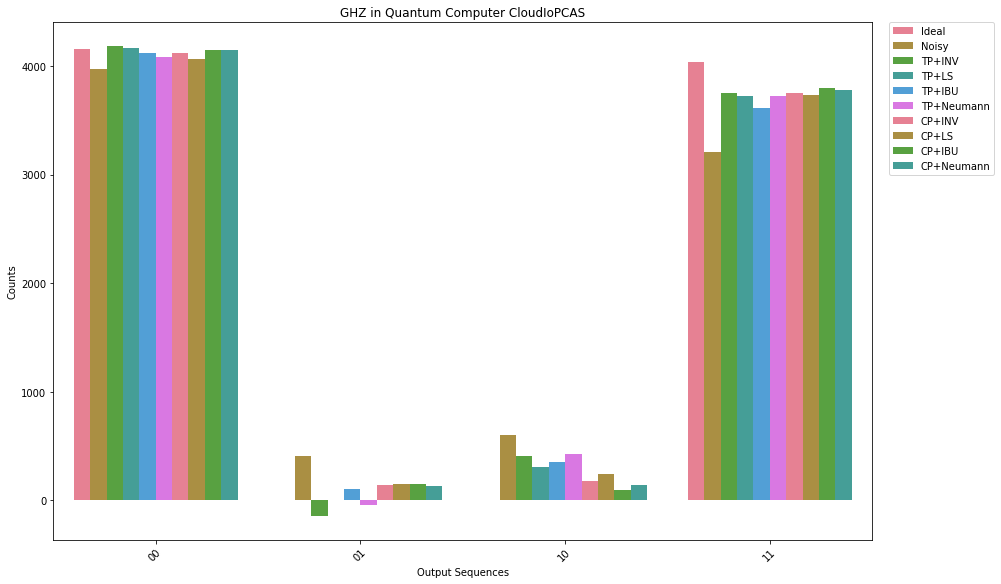

In [15]:
# Visualize the ideal, noisy, and mitigated counts
counts_list = [dict2vector(counts_ideal),
               dict2vector(counts_noisy),
               dict2vector(counts_tp_inv), dict2vector(counts_tp_ls), dict2vector(counts_tp_ibu), dict2vector(counts_tp_neu),
               dict2vector(counts_cp_inv), dict2vector(counts_cp_ls), dict2vector(counts_cp_ibu), dict2vector(counts_cp_neu)]
legends = ['Ideal', 'Noisy', 'TP+INV', 'TP+LS', 'TP+IBU', 'TP+Neumann', 'CP+INV', 'CP+LS', 'CP+IBU', 'CP+Neumann']

plot_histograms(counts_list, legends,
                title="GHZ in Quantum Computer {}".format(noisy_qc_name),
                fig_name="GHZ_Counts_MEM_{}_N{}.png".format(noisy_qc_name, n))



然后是期望值。可以注意到，在八种校准和修正的组合中，都有明显的改善。

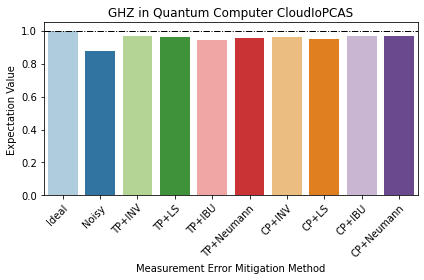

In [16]:
# Visualize the ideal, noisy, and mitigated expectation values
plt.figure()
ax = plt.gca()

expval_list = [val_ideal, val_noisy, val_tp_inv, val_tp_ls, val_tp_ibu, val_tp_neu, val_cp_inv, val_cp_ls, val_cp_ibu, val_cp_neu]
expval_array = np.zeros((len(expval_list), 2))
for i, val in enumerate(expval_list):
    expval_array[i][0] = i
    expval_array[i][1] = val

df = pandas.DataFrame(expval_array, columns=["Measurement Error Mitigation Method", "Expectation Value"])
seaborn.barplot(x=df['Measurement Error Mitigation Method'],
                y=df['Expectation Value'],
                palette=seaborn.color_palette("Paired"))

# Add the theoretical reference line
plt.axhline(y=1, color='black', linestyle='-.', linewidth=1, zorder=1)

ax.set_xticklabels(legends)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("GHZ in Quantum Computer {}".format(noisy_qc_name), fontsize=12)
plt.tight_layout()

plt.savefig("GHZ_ExpVal_MEM_{}_N{}.png".format(noisy_qc_name, n),
            format='png',
            dpi=600,
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

## 总结
通过 GHZ 态的简单例子，我们可以看到校准与修正是如何应用到计算过程当中的，以及他们各自扮演了什么样的角色，相互是如何配合对含有测量噪声的统计结果进行修正的。

根据这八个校准与修正的不同组合的结果，我们可以看到效果都非常好，理论上讲，对比张量积校准，基于无结构校准的修正结果普遍更接近真值，这是因为无结构校准以资源为代价来获得测量噪声的全部统计学信息，在实际应用当中，需要对两种校准方法进行一个权衡，因为我们也能看到，基于张量积校准的修正结果也有相当好的准确度，是一种性价比高的模型。

## 参考资料

[1] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." [Nature Communications](https://www.nature.com/articles/ncomms5213), 5.1 (2014): 1-7.

[2] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." [arXiv](https://arxiv.org/abs/1411.4028) preprint arXiv:1411.4028, 2014.

[3] Biamonte, Jacob, et al. "Quantum machine learning." [Nature](https://www.nature.com/articles/nature23474) 549.7671 (2017): 195-202.

[4] Havlíček, Vojtěch, et al. "Supervised learning with quantum-enhanced feature spaces." [Nature](https://www.nature.com/articles/s41586-019-0980-2), 567.7747 (2019): 209-212.

[5] Chow, Jerry M., et al. "Universal quantum gate set approaching fault-tolerant thresholds with superconducting qubits." [Physical Review Letters](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.060501) 109.6 (2012): 060501.

[6] Kandala, Abhinav, et al. "Error mitigation extends the computational reach of a noisy quantum processor." [Nature](https://www.nature.com/articles/s41586-019-1040-7), 567.7749 (2019): 491-495.

[7] Michael R Geller. "Rigorous measurement error correction." [Quantum Science and Technology](https://iopscience.iop.org/article/10.1088/2058-9565/ab9591), 5(3):03LT01, 2020.

[8] Wikipedia contributors. "Computational complexity of mathematical operations." [Wikipedia](https://zh.wikipedia.org/wiki/%E8%B4%9D%E5%8F%B6%E6%96%AF%E5%AE%9A%E7%90%86), 2021. 

[9] Wikipedia contributors. "Moore–Penrose inverse." [Wikipedia](https://en.wikipedia.org/w/index.php?title=Moore%E2%80%93Penrose_inverse&oldid=1022461613), 2021.

[10] Wikipedia contributors. "Bayes' theorem." [Wikipedia](https://en.wikipedia.org/w/index.php?title=Bayes%27_theorem&oldid=1042323607), 2021.

[11] Nachman, Benjamin, et al. "Unfolding quantum computer readout noise." [npj Quantum Information](https://arxiv.org/abs/1910.01969) 6.1 (2020): 1-7.

[12] Wang, Kun, Yu-Ao Chen, and Xin Wang. "Measurement Error Mitigation via Truncated Neumann Series." [arXiv](https://arxiv.org/abs/2103.13856) preprint arXiv:2103.13856, 2021.